Author: Oliver Bestel de Lezongard (914956)

Purpose of this file is download rasterdata of Wildfires around Australia during the 2019-2020 Australian Bushfire Season.

Note that this code follows https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html and https://sentinelhub-py.readthedocs.io/en/latest/examples/data_search.html docs to use SentinelHub process API and Catalog API for data gathering

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## Using Python 3.10 

import datetime as dt 
import matplotlib.pyplot as plt
import numpy as np
import os
from sentinelhub import CRS, BBox
import cv2

import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook. Can be found in sentinel hub repositories in their examples.
from utils import plot_image


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DOWNLOADING THE DATA
---
---
---

In [ ]:
## Import config file

from sentinelhub import SHConfig
config = SHConfig()


if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [ ]:
## Use this to get the conffiguration of your config file. 

SHConfig.get_config_location()

'/Users/oliverbestel/.config/sentinelhub/config.toml'

In [5]:
## To see available data collections

print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

In [142]:
## Define test box to play round with functions 


test_box = BBox((150.5,-32.6,151,-32.2),CRS.WGS84)

resolution = 20
betsiboka_bbox = BBox(bbox=test_box, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

x, y = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(x)
print(y)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

2305
2267
Image shape at 20 m resolution: (2305, 2267) pixels


In [65]:
## This generates all the bounding boxes over the region of NSW that we are interested in 

start_lat = - 30
start_long = 150

limit_lat = -35
limit_long = 153.5

lat = start_lat
long = start_long

i = 0 
bboxes = []
while lat >= limit_lat:

    long = start_long

    # print(lat,long)

    while long <= limit_long:

        box = BBox((long,lat,long +0.5,lat - 0.4),CRS.WGS84)

        bboxes.append(box)
        
        x, y = bbox_to_dimensions(box, resolution=20)

        if x >= 2500:
            print('failed x ', i)

        if y >= 2500:
            print('failed y ', i)
            
        if lat < -33.5 and long>151.4:
        
           long = 200
        # print(lat,long)



        i +=1
        long += 0.5

    lat -= 0.4





In [73]:
bboxes[0:10]

[BBox(((150.0, -30.4), (150.5, -30.0)), crs=CRS('4326')),
 BBox(((150.5, -30.4), (151.0, -30.0)), crs=CRS('4326')),
 BBox(((151.0, -30.4), (151.5, -30.0)), crs=CRS('4326')),
 BBox(((151.5, -30.4), (152.0, -30.0)), crs=CRS('4326')),
 BBox(((152.0, -30.4), (152.5, -30.0)), crs=CRS('4326')),
 BBox(((152.5, -30.4), (153.0, -30.0)), crs=CRS('4326')),
 BBox(((153.0, -30.4), (153.5, -30.0)), crs=CRS('4326')),
 BBox(((153.5, -30.4), (154.0, -30.0)), crs=CRS('4326')),
 BBox(((150.0, -30.799999999999997), (150.5, -30.4)), crs=CRS('4326')),
 BBox(((150.5, -30.799999999999997), (151.0, -30.4)), crs=CRS('4326'))]

Note that for downloading all the images, we did it per 10 bounding boxes at a time as it was prone to failure and then you lose mark of where you are and have to restart the whole process. SentinelHub has a limited number of processing units and requests on their free acouints, thus many accounts had to made to download all the data

UNLABELLED IMAGE
---
---

In [68]:
## allows for downloading of time series data between two time intervals 

from sentinelhub import SentinelHubCatalog

catalog = SentinelHubCatalog(config=config)

In [74]:
## Downloading the unlabelled images
p = 0 
i = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_true_color = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    }
                };
            }

            function evaluatePixel(sample) {
                return [sample.B04, sample.B03, sample.B02];
            }
        """

    for box in bboxes[0:10]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_true_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("true_images/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
29


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


1  is done
2
43
2  is done
3
57
3  is done
4
72
4  is done
5
92
5  is done
6
113
6  is done
7
125
7  is done
8
135
8  is done
9
167
9  is done
10
183
10  is done


In [75]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_true_color = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    }
                };
            }

            function evaluatePixel(sample) {
                return [sample.B04, sample.B03, sample.B02];
            }
        """

    for box in bboxes[10:20]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_true_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("true_images/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
16
1  is done
2
43


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


2  is done
3
73
3  is done
4
101
4  is done
5
117
5  is done
6
130
6  is done
7
158


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


7  is done
8
174
8  is done
9
190
9  is done
10
220


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

10  is done


In [76]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_true_color = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    }
                };
            }

            function evaluatePixel(sample) {
                return [sample.B04, sample.B03, sample.B02];
            }
        """

    for box in bboxes[20:30]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_true_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("true_images/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
30
1  is done
2
58


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


2  is done
3
74
3  is done
4
87
4  is done
5
115


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

5  is done
6
128
6  is done
7
141
7  is done
8
167


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


8  is done
9
193
9  is done
10
214
10  is done


In [77]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_true_color = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    }
                };
            }

            function evaluatePixel(sample) {
                return [sample.B04, sample.B03, sample.B02];
            }
        """

    for box in bboxes[30:40]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_true_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("true_images/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
12
1  is done
2
22
2  is done
3
36
3  is done
4
49
4  is done
5
59
5  is done
6
88


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

6  is done
7
117


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


7  is done
8
131
8  is done
9
145
9  is done
10
157
10  is done


In [78]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_true_color = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    }
                };
            }

            function evaluatePixel(sample) {
                return [sample.B04, sample.B03, sample.B02];
            }
        """

    for box in bboxes[40:50]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_true_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("true_images/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
11
1  is done
2
21
2  is done
3
29
3  is done
4
54
4  is done
5
79


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


5  is done
6
91
6  is done
7
103
7  is done
8
114
8  is done
9
127
9  is done
10
140
10  is done


In [79]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_true_color = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    }
                };
            }

            function evaluatePixel(sample) {
                return [sample.B04, sample.B03, sample.B02];
            }
        """

    for box in bboxes[50:60]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_true_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("true_images/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
27


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

1  is done
2
54


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


2  is done
3
81


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


3  is done
4
95
4  is done
5
109
5  is done
6
121
6  is done
7
132
7  is done
8
144
8  is done
9
168


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


9  is done
10
192


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


10  is done


In [80]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_true_color = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    }
                };
            }

            function evaluatePixel(sample) {
                return [sample.B04, sample.B03, sample.B02];
            }
        """

    for box in bboxes[60:70]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_true_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("true_images/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
24


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


1  is done
2
35
2  is done
3
46
3  is done
4
55
4  is done
5
66
5  is done
6
78
6  is done
7
102
7  is done
8
127


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


8  is done
9
151


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

9  is done
10
163
10  is done


In [81]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_true_color = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    }
                };
            }

            function evaluatePixel(sample) {
                return [sample.B04, sample.B03, sample.B02];
            }
        """

    for box in bboxes[70:80]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_true_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("true_images/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
12
1  is done
2
23
2  is done
3
31
3  is done
4
43
4  is done
5
66
5  is done
6
89
6  is done
7
100
7  is done
8
126


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


8  is done
9
150


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


9  is done
10
174


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


10  is done


In [82]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_true_color = """
            //VERSION=3

            function setup() {
                return {
                    input: [{
                        bands: ["B02", "B03", "B04"]
                    }],
                    output: {
                        bands: 3
                    }
                };
            }

            function evaluatePixel(sample) {
                return [sample.B04, sample.B03, sample.B02];
            }
        """

    for box in bboxes[80:]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_true_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("true_images/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
10


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


1  is done
2
36


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


2  is done
3
60


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


3  is done
4
84


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


4  is done
5
93
5  is done
6
114


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


6  is done
7
130
7  is done
8
148
8  is done


MASKS
---
---

In [87]:
## Downloading the unlabelled images
i = 0 
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes[0:10]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images2/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
29


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


1  is done
2
43
2  is done
3
57


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

3  is done
4
72


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

4  is done
5
92


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

5  is done
6
113


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


6  is done
7
125
7  is done
8
135


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

8  is done
9
167


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

9  is done
10
183
10  is done


In [88]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes[10:20]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images2/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
16


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

1  is done
2
43


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

2  is done
3
73


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


3  is done
4
101


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


4  is done
5
117


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

5  is done
6
130


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

6  is done
7
158


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

7  is done
8
174


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


8  is done
9
190
9  is done
10
220


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

10  is done


In [89]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes[20:30]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images2/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
30


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


1  is done
2
58


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

2  is done
3
74
3  is done
4
87


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

4  is done
5
115


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

5  is done
6
128
6  is done
7
141
7  is done
8
167


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

8  is done
9
193


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


9  is done
10
214


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

10  is done


In [200]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes[30:40]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images2/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1


KeyboardInterrupt: 

In [207]:
## This was done as we experienced failures and wanted to resume at close the point where we had lost it. i was used to count.
i = 774 

In [213]:
from sentinelhub import SHConfig


config = SHConfig()


if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

## allows for downloading of time series data between two time intervals 

from sentinelhub import SentinelHubCatalog

catalog = SentinelHubCatalog(config=config)

In [208]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes[40:50]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        # results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images2/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
11
1  is done
2
21
2  is done
3
29


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


3  is done
4
54


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

4  is done
5
79


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

5  is done
6
91
6  is done
7
103


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

7  is done
8
114


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

8  is done
9
127


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


9  is done
10
140
10  is done


In [209]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes[50:60]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images2/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
27


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

1  is done
2
54


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

2  is done
3
81


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

3  is done
4
95


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

4  is done
5
109


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


5  is done
6
121


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

6  is done
7
132


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


7  is done
8
144
8  is done
9
168


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

9  is done
10
192


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

10  is done


In [210]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes[60:70]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images2/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
24


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

1  is done
2
35


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


2  is done
3
46


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


3  is done
4
55
4  is done
5
66


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

5  is done
6
78


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


6  is done
7
102


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

7  is done
8
127


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


8  is done
9
151


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

9  is done
10
163
10  is done


In [211]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes[70:80]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images2/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
12


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

1  is done
2
23


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


2  is done
3
31
3  is done
4
43


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


4  is done
5
66


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


5  is done
6
89


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

6  is done
7
100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


7  is done
8
126


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

8  is done
9
150


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

9  is done
10
174


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

10  is done


In [216]:
i = 1443

In [217]:
## Downloading the unlabelled images
p = 0 
sum = 0 
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

if True: ## Set to true if you want to redownload the data 


    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes[80:]:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)




        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images2/" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
10


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


1  is done
2
36


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


2  is done
3
60


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

3  is done
4
84


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

4  is done
5
93


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

5  is done
6
114


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

6  is done
7
130


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

7  is done
8
148


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

8  is done


In [34]:
p = 0 
i = 0 
sum = 0 

if True: 

    from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

    evalscript_label_color = """

    function setup() {
        return {
            input: ["B02","B03","B04", "B11","B12"],
            output: { bands: 3 }
        };
        }

        function evaluatePixel(sample){
            var NGDR = index(sample.B02, sample.B03);
            var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
            //Fire indicator
            var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

            if (Inverse > 1) { 
                return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
            }

            if (Inverse > 0 && NGDR>0) { 
                return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
            }

            if((SAHM_INDEX>0.4)||(sample.B12>1)){
            return[20*sample.B04, 1*sample.B03, 1*sample.B02];
            }

            else {
            return [sample.B04,sample.B04,sample.B04]
            }
        }

        """

    for box in bboxes:

        p +=1
        print(p)

        bbox = box
        time_interval = "2019-09-01", "2020-01-01"


        search_iterator = catalog.search(
            DataCollection.SENTINEL2_L2A,
            bbox=bbox,
            time=time_interval,
            filter="eo:cloud_cover < 1", ## Filter for cloud cover less than certain percentage (data has <20, and data_nc has <2)
            fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
        )

        results = list(search_iterator)
        # print("Total number of results:", len(results))


        

        time_difference = dt.timedelta(hours=1)

        all_timestamps = search_iterator.get_timestamps()
        unique_acquisitions = filter_times(all_timestamps, time_difference)

        # print("Number of unique timestamps: ", len(unique_acquisitions))
        unique_acquisitions

        sum += len(unique_acquisitions)

        print(sum)



        process_requests = []

        for timestamp in unique_acquisitions:
            request = SentinelHubRequest(
                evalscript=evalscript_label_color,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L2A,
                        time_interval=(timestamp - time_difference, timestamp + time_difference),
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
                bbox=bbox,
                size=bbox_to_dimensions(bbox, resolution = 20),
                config=config,
            )
            process_requests.append(request)


        client = SentinelHubDownloadClient(config=config)

        download_requests = [request.download_list[0] for request in process_requests]

        data = client.download(download_requests)

        data[0].shape

        for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):

            cv2.imwrite("mask_images/v2" + str(i) + "_" +  str(timestamp.date()) + ".png", image) 

            i += 1

        print(p, " is done")

1
29


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


1  is done
2
43


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

2  is done
3
57


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

3  is done
4
72


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

4  is done
5
92


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

5  is done
6
113


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


6  is done
7
125


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

7  is done
8
135


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

8  is done
9
167


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

9  is done
10
183
10  is done
11
199


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

11  is done
12
226


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

12  is done
13
256


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

13  is done
14
284


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

14  is done
15
300


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

15  is done
16
313


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

16  is done
17
341


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

17  is done
18
357
18  is done
19
373


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

19  is done
20
403


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:87: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Library/Frameworks/Python.framework

20  is done
21


DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/api/v1/catalog/1.0.0/search
with HTTPError:
403 Client Error: Forbidden for url: https://services.sentinel-hub.com/api/v1/catalog/1.0.0/search
Server response: "{"code": 403, "description": "Invalid or expired account."}"

Different Annotation Approaches
---
---

Evaluating different ways to get active fire labels 
- Appears the one from https://custom-scripts.sentinel-hub.com/sentinel-2/active_fire_detection/ seems to be the best

Image type: uint8


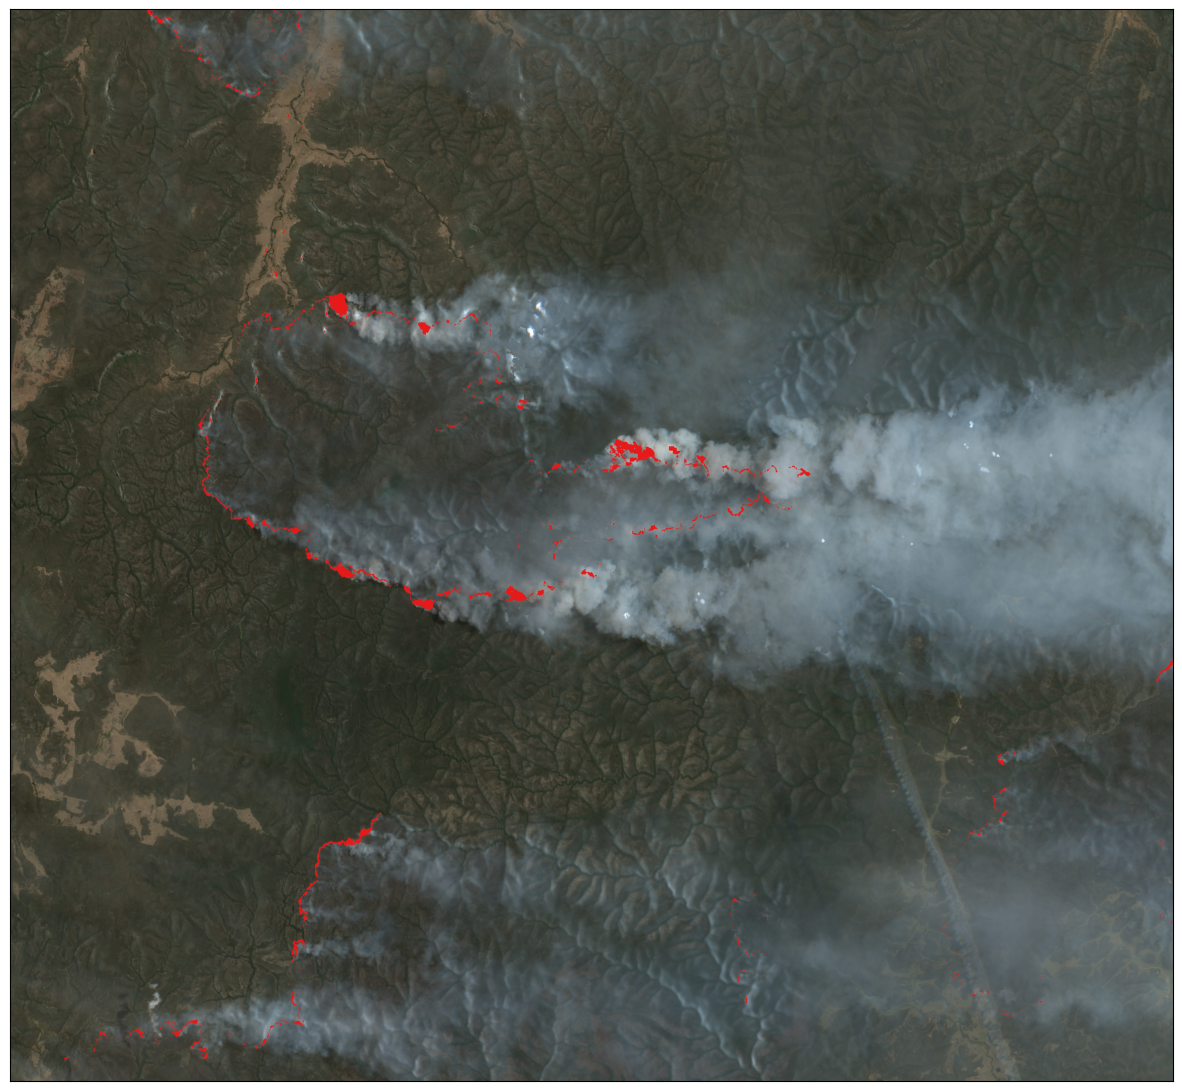

In [193]:
## Piere NMarkruse V3

evalscript_label_color  = """
// VERSION=3
// QuickFire V1.0.0 by Pierre Markuse (https://twitter.com/Pierre_Markuse)
// Made for use in the Sentinel Hub EO Browser (https://apps.sentinel-hub.com/eo-browser/?)
// CC BY 4.0 International (https://creativecommons.org/licenses/by/4.0/)

function setup() {
  return {
    input: ["B01","B02","B03","B04","B08","B8A","B11","B12","CLP", "dataMask"],
    output: { bands: 4 }
  };
}

function stretch(val, min, max) {return (val - min) / (max - min);} 

function satEnh(arr, s) {
   var avg = arr.reduce((a, b) => a + b, 0) / arr.length;
   return arr.map(a => avg * (1 - s) + a * s);
}

 function layerBlend(lay1, lay2, lay3, op1, op2, op3) {
    return lay1.map(function(num, index) {
     return (num / 100 * op1 + (lay2[index] / 100 * op2) + (lay3[index] / 100 * op3));
    });
  }  

function evaluatePixel(sample) {
  const hsThreshold = [2.0, 1.5, 1.25, 1.0];
  const hotspot = 1;
  const style = 1;
  const hsSensitivity = 1.0;
  const boost = 1;
  const RED = [0.9, 0.1, 0.1] ; 
  
  const cloudAvoidance = 1;
  const cloudAvoidanceThreshold = 245;
  const avoidanceHelper = 0.8;

  const offset = -0.000;
  const saturation = 1.10;
  const brightness = 1.00;
  const sMin = 0.01;
  const sMax = 0.99;
  

  const NDWI = (sample.B03-sample.B08)/(sample.B03+sample.B08);
  const NDVI = (sample.B08-sample.B04)/(sample.B08+sample.B04);
  const waterHighlight = 0;
  const waterBoost = 2.0;
  const NDVI_threshold = -0.15;
  const NDWI_threshold = 0.15;
  const waterHelper = 0.2;
  
  const Black = [0, 0, 0];
  const NBRindex = (sample.B08-sample.B12) / (sample.B08+sample.B12); 
  const naturalColorsCC = [Math.sqrt(brightness * sample.B04 + offset), Math.sqrt(brightness * sample.B03 + offset), Math.sqrt(brightness * sample.B02 + offset)];
  const naturalColors = [(2.5 * brightness * sample.B04 + offset), (2.5 * brightness * sample.B03 + offset), (2.5 * brightness * sample.B02 + offset)];
  const URBAN = [Math.sqrt(brightness * sample.B12 * 1.2 + offset), Math.sqrt(brightness * sample.B11 * 1.4 + offset), Math.sqrt(brightness * sample.B04 + offset)];
  const SWIR = [Math.sqrt(brightness * sample.B12 + offset), Math.sqrt(brightness * sample.B8A + offset), Math.sqrt(brightness * sample.B04 + offset)];
  const NIRblue = colorBlend(sample.B08, [0, 0.25, 1], [[0/255, 0/255, 0/255],[0/255, 100/255, 175/255],[150/255, 230/255, 255/255]]);
  const classicFalse = [sample.B08 * brightness, sample.B04 * brightness, sample.B03 * brightness];
  const NIR = [sample.B08 * brightness, sample.B08 * brightness, sample.B08 * brightness];
  const atmoPen = [sample.B12 * brightness, sample.B11 * brightness, sample.B08 * brightness];
  var enhNaturalColors = [0, 0, 0];
  for (let i = 0; i < 3; i += 1) { enhNaturalColors[i] = (brightness * ((naturalColors[i] + naturalColorsCC[i]) / 2) + (URBAN[i] / 10)); }
  
  const manualCorrection = [0.00, 0.00, 0.00];
  
  var Viz = layerBlend(URBAN, naturalColors, naturalColorsCC, 10, 40, 50); // Choose visualization(s) and opacity here


  if (hotspot) {  
    if ((!cloudAvoidance) || ((sample.CLP<cloudAvoidanceThreshold) && (sample.B02<avoidanceHelper))) {
     switch (style) {
       case 1:
        if ((sample.B12 + sample.B11) > (hsThreshold[0] / hsSensitivity)) return [0.9, 0.1, 0.1, sample.dataMask]; 
        if ((sample.B12 + sample.B11) > (hsThreshold[1] / hsSensitivity)) return [0.9, 0.1, 0.1, sample.dataMask]; 
        if ((sample.B12 + sample.B11) > (hsThreshold[2] / hsSensitivity)) return [0.9, 0.1, 0.1, sample.dataMask];  
        if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [0.9, 0.1, 0.1, sample.dataMask]; 
       break;
       case 2:
        if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [1, 0, 0, sample.dataMask]; 
       break;
       case 3:
        if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [1, 1, 0, sample.dataMask]; 
       break;
       case 4:  
        if ((sample.B12 + sample.B11) > (hsThreshold[3] / hsSensitivity)) return [Viz[0] + 0.2, Viz[1] - 0.2, Viz[2] - 0.2, sample.dataMask];
       break;
       default:
      }
    }
  }



  return [Viz[0], Viz[1], Viz[2], sample.dataMask];
}

 """

bb = BBox((150.236764,-32.96625,150.749324,-32.585723), CRS.WGS84)
request_true_color = SentinelHubRequest(
    evalscript=evalscript_label_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            # data_collection=DataCollection.MODIS,
            time_interval=("2019-12-06", "2019-12-06"),
        ) 
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bb,
    size = bbox_to_dimensions(bb, resolution=20),
    # resolution= 100, 
    config=config,
)

true_color_imgs = request_true_color.get_data()

image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness

plot_image(image,1/255,clip_range=(0, 1)) 

Image type: uint8


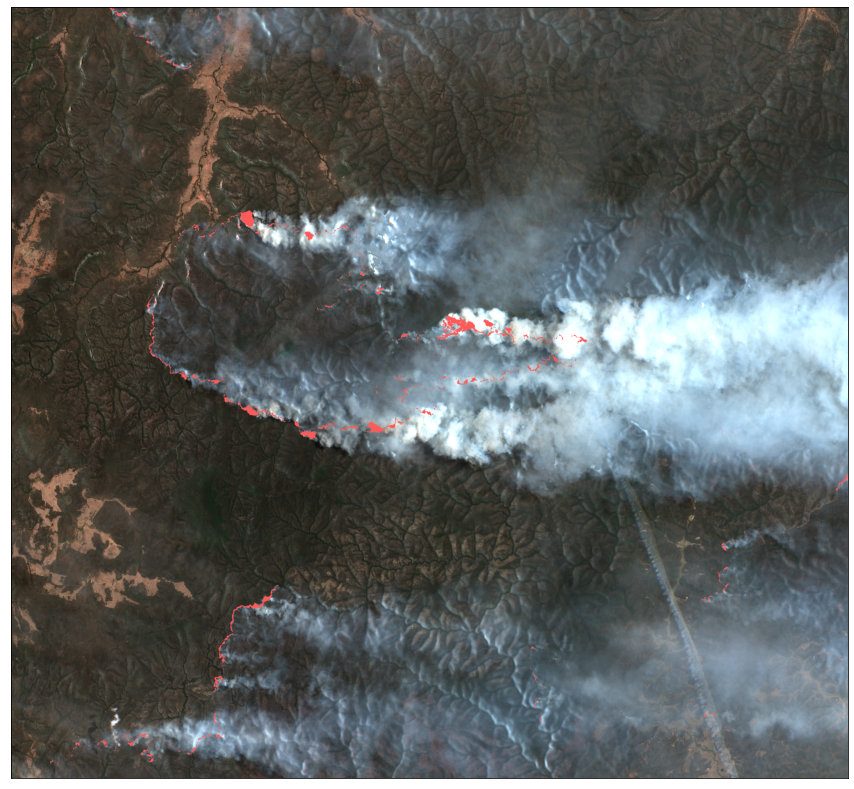

In [42]:
## Pierre Markruse V1 
evalscript_label_color = """
        //VERSION=3

    function setup() {
    return {
        input: ["B02","B03","B04", "B11","B12"],
        output: { bands: 3 }
    };
    }
 
   

    function evaluatePixel(sample){
    
        if ((sample.B12 + sample.B11) > (1.0)){
        return[0.9, 0.1, 0.1]
        } return [sample.B04, sample.B03, sample.B02]
    
    }
    """


bb = BBox((150.236764,-32.96625,150.749324,-32.585723), CRS.WGS84)
request_true_color = SentinelHubRequest(
    evalscript=evalscript_label_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            # data_collection=DataCollection.MODIS,
            time_interval=("2019-12-06", "2019-12-06"),
        ) 
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bb,
    size = bbox_to_dimensions(bb, resolution=20),
    # resolution= 100, 
    config=config,
)

true_color_imgs = request_true_color.get_data()

image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness

plot_image(image, factor=3.5 / 255, clip_range=(0, 1)) 

Image type: uint8


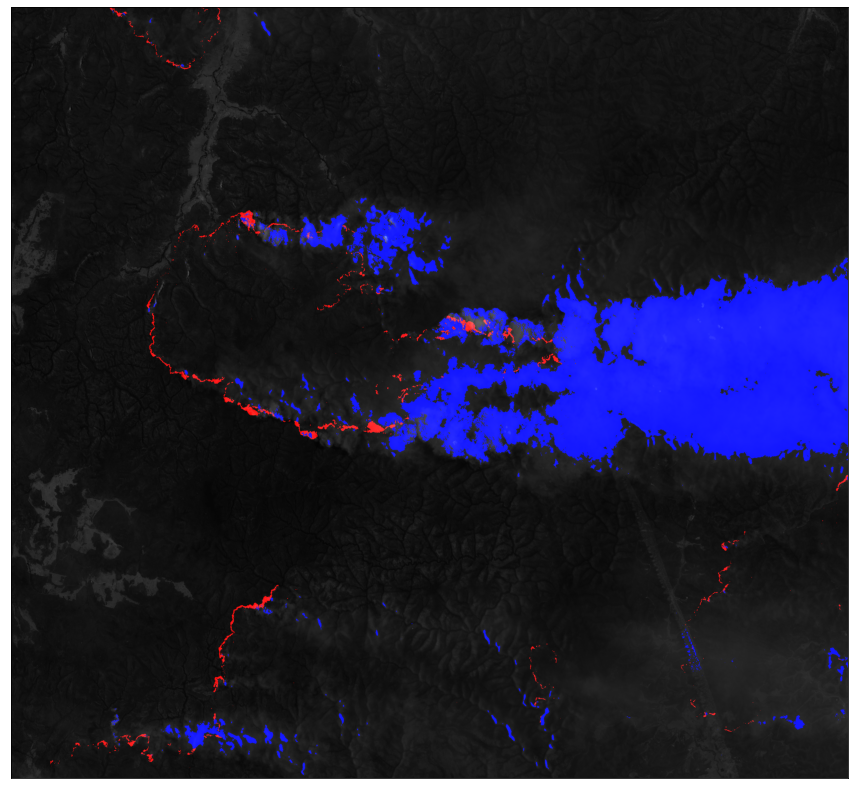

In [43]:


## https://custom-scripts.sentinel-hub.com/sentinel-2/active_fire_detection/
evalscript_label_color = """

   function setup() {
    return {
        input: ["B02","B03","B04", "B11","B12"],
        output: { bands: 3 }
    };
    }

    function evaluatePixel(sample){
        var NGDR = index(sample.B02, sample.B03);
        var Inverse = (sample.B02 - 0.2) / (0.5 - 0.2);
        //Fire indicator
        var SAHM_INDEX= ((sample.B12 - sample.B11) / (sample.B12 + sample.B11));

        if (Inverse > 1) { 
            return [0.5 * sample.B04, 0.5 * sample.B03, 20 * sample.B02 ];
        }

        if (Inverse > 0 && NGDR>0) { 
            return [0.5 * sample.B04  , 0.5 * sample.B03, 20 * sample.B02];
        }

        if((SAHM_INDEX>0.4)||(sample.B12>1)){
        return[20*sample.B04, 1*sample.B03, 1*sample.B02];
        }

        else {
        return [sample.B04,sample.B04,sample.B04]
        }
    }

    """


bb = BBox((150.236764,-32.96625,150.749324,-32.585723), CRS.WGS84)
request_true_color = SentinelHubRequest(
    evalscript=evalscript_label_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            # data_collection=DataCollection.MODIS,
            time_interval=("2019-12-06", "2019-12-06"),
        ) 
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bb,
    size = bbox_to_dimensions(bb, resolution=20),
    # resolution= 100, 
    config=config,
)

true_color_imgs = request_true_color.get_data()

image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness

plot_image(image, factor=1 / 255, clip_range=(0, 1)) 

Creating the true label masks for the images
---


In [62]:
os.getcwd()

'/Users/oliverbestel/Desktop/COMP90055'

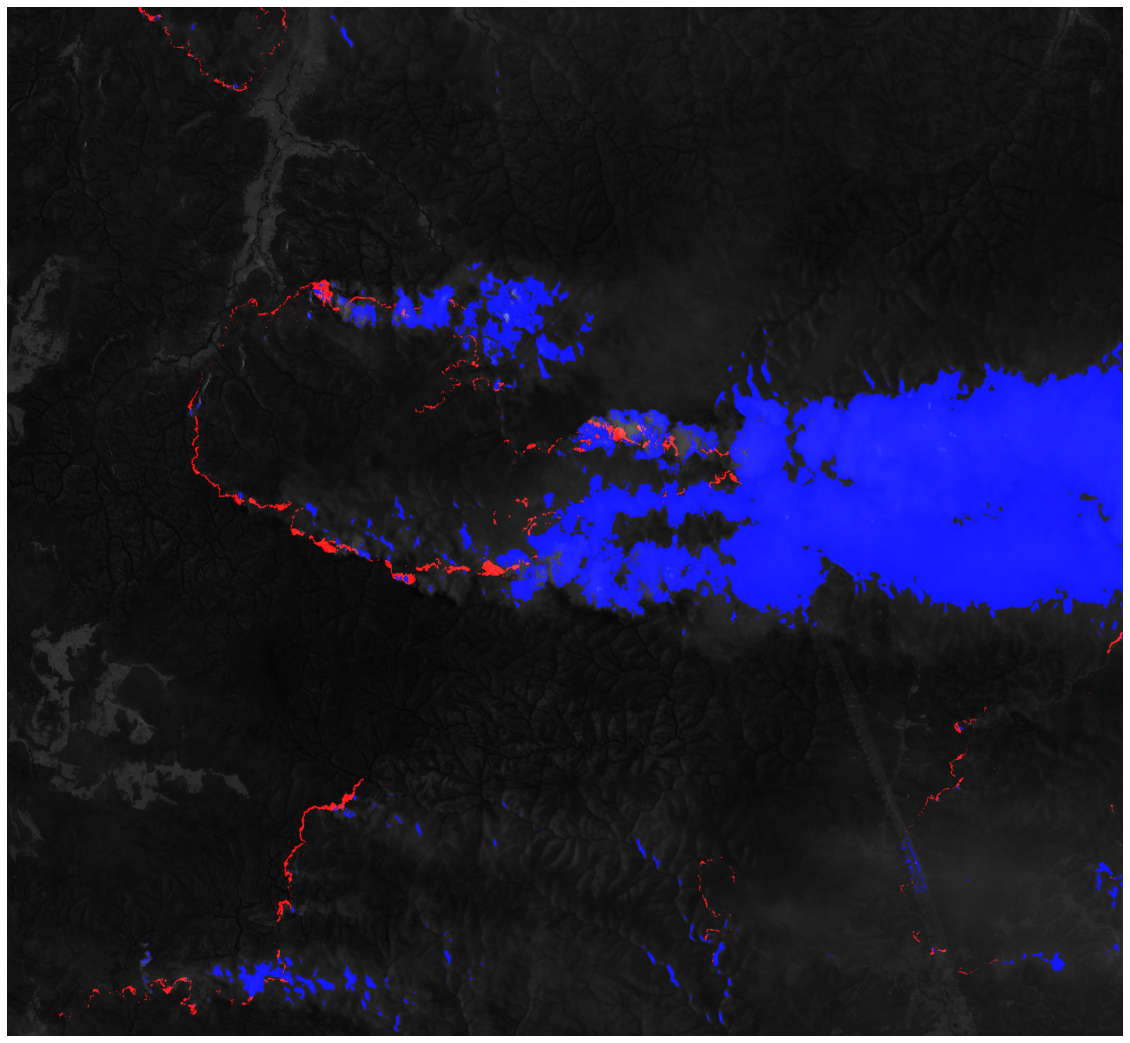

In [102]:
img = cv2.imread("data_label2/L_FS1_Gospers12019-12-06.png")
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)



plt.figure(figsize = (20,20))
plt.imshow(img)
plt.axis("off")
plt.show()


(2167, 2351, 3)


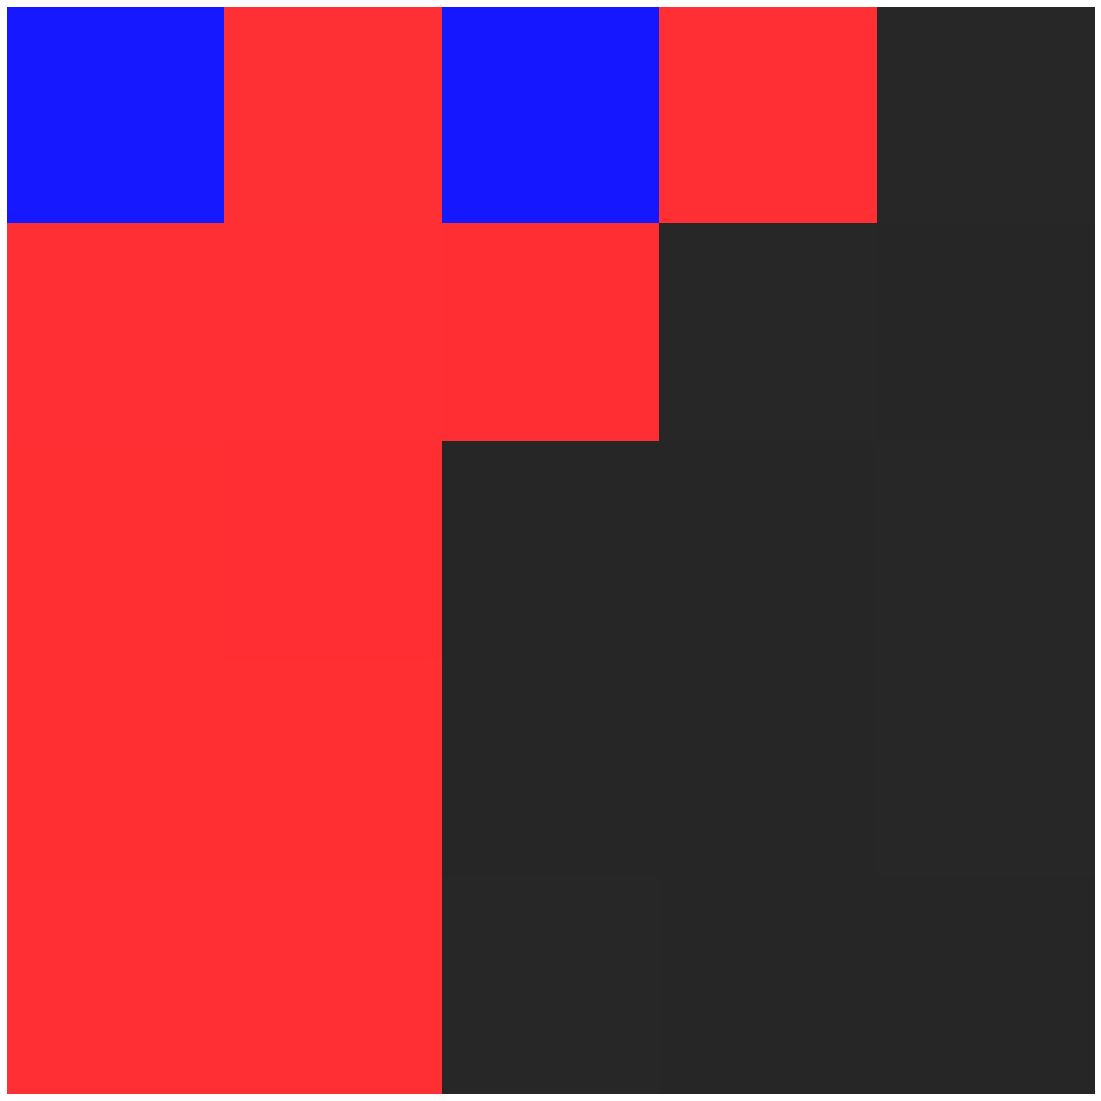

In [89]:
print(img.shape)
# subsection = img[]
subsection =img[1100:1105, 1100:1105, :]

plt.figure(figsize = (20,20))
plt.imshow(subsection)
plt.axis("off")
plt.show()


In [90]:
subsection

## This shows us that fire sections are characterised by a RED channel with value 255, 
# ## and cloud sections are characterised by a BLUE channel of 255

array([[[ 22,  24, 255],
        [255,  48,  51],
        [ 21,  24, 255],
        [255,  47,  51],
        [ 39,  39,  39]],

       [[255,  47,  51],
        [255,  47,  51],
        [255,  46,  50],
        [ 39,  39,  39],
        [ 38,  38,  38]],

       [[255,  47,  50],
        [255,  46,  50],
        [ 38,  38,  38],
        [ 38,  38,  38],
        [ 39,  39,  39]],

       [[255,  47,  50],
        [255,  47,  50],
        [ 38,  38,  38],
        [ 38,  38,  38],
        [ 39,  39,  39]],

       [[255,  47,  51],
        [255,  47,  51],
        [ 39,  39,  39],
        [ 38,  38,  38],
        [ 38,  38,  38]]], dtype=uint8)

This shows us that fire sections are characterised by a RED channel with value 255, 
and cloud sections are characterised by a BLUE channel of 255

Thus we do some vector operations to create a mask. 
We will create a mask that splits the pixels into fire, no fire.
We will create a second mask that splits the pixels into fire, cloud, background.

In [ ]:
## Firstly fire, no fire. 

img = cv2.imread("data_label2/L_FS1_Gospers12019-12-06.png")
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img[img[:,:,0]!=255] = 0
img[img[:,:,0]==255] = 1 ## Set this to 255 if want to see clearly in image ## Indicates that is fire (Class = 1 -> Fire)

plt.figure(figsize = (20,20))
plt.imshow(img)
plt.axis("off")
plt.show()

In [144]:
label2_dir = os.listdir('data_label2')

for img_name in label2_dir:
    print(img_name)
    img = cv2.imread('data_label2/' + img_name)
    img[img[:,:,0]!=255] = 0
    img[img[:,:,0]==255] = 1
    cv2.imwrite("data_label2_masks_fnf/M" + img_name , img) 

        


L_NFS32020-01-05.png
L_NFS22020-01-23.png
L_NFS72020-03-01.png
L_NFS12019-12-13.png
L_NFS62019-12-17.png
L_NFS42020-01-01.png
L_NFS52019-12-12.png
L_FS3_Currowan2019-12-26.png
L_NFS52019-12-07.png
L_NFS42019-12-21.png
L_NFS52020-01-26.png
L_NFS72020-01-11.png
L_NFS12019-12-06.png
L_NFS12020-01-27.png
L_FS5_EGippsland2019-11-21.png
L_NFS22019-12-17.png
L_NFS32020-01-10.png
L_NFS22020-01-08.png
L_NFS12020-01-25.png
L_FS4_OrroralValley2019-12-04.png
L_FS4_OrroralValley2020-01-25.png
L_NFS62020-01-21.png
L_FS3_Currowan2020-01-10.png
L_FS1_Gospers12020-02-04.png
L_FS6_KangarooIsland2020-02-09.png
L_NFS52020-01-31.png
L_NFS72019-12-27.png
L_FS4_OrroralValley2020-01-30.png
L_FS4_OrroralValley2019-12-11.png
L_NFS12019-12-11.png
L_NFS12020-01-30.png
L_FS2_Gospers22020-02-04.png
L_NFS32019-12-26.png
L_FS5_EGippsland2020-02-17.png
L_NFS22019-12-14.png
L_NFS22019-12-04.png
L_NFS22020-01-31.png
L_FS5_EGippsland2020-02-07.png
L_FS2_Gospers22020-02-14.png
L_FS2_Gospers22019-11-21.png
L_FS4_OrroralVal

In [145]:
## Fire no fire for dataset with less cloud cover

label2_dir = os.listdir('data_nc_label2')

for img_name in label2_dir:
    print(img_name)
    img = cv2.imread('data_label2/' + img_name)
    img[img[:,:,0]!=255] = 0
    img[img[:,:,0]==255] = 1
    cv2.imwrite("data_nc_label2_masks_fnf/M" + img_name , img) 

        

L_NFS32020-01-05.png
L_NFS22020-01-23.png
L_NFS72020-03-01.png
L_NFS12019-12-13.png
L_NFS62019-12-17.png
L_NFS42020-01-01.png
L_FS3_Currowan2019-12-26.png
L_NFS52019-12-07.png
L_NFS42019-12-21.png
L_NFS52020-01-26.png
L_NFS72020-01-11.png
L_NFS12019-12-06.png
L_NFS12020-01-27.png
L_NFS22019-12-17.png
L_NFS32020-01-10.png
L_NFS22020-01-08.png
L_NFS12020-01-25.png
L_FS4_OrroralValley2019-12-04.png
L_FS4_OrroralValley2020-01-25.png
L_NFS62020-01-21.png
L_FS1_Gospers12020-02-04.png
L_FS6_KangarooIsland2020-02-09.png
L_NFS52020-01-31.png
L_FS4_OrroralValley2020-01-30.png
L_FS4_OrroralValley2019-12-11.png
L_NFS12019-12-11.png
L_NFS12020-01-30.png
L_FS2_Gospers22020-02-04.png
L_NFS32019-12-26.png
L_NFS22019-12-14.png
L_NFS22019-12-04.png
L_NFS22020-01-31.png
L_FS4_OrroralValley2020-01-08.png
L_NFS52020-01-21.png
L_FS1_Gospers12019-11-21.png
L_FS6_KangarooIsland2020-02-24.png
L_NFS42019-12-27.png
L_NFS72019-12-22.png
L_NFS12019-12-28.png
L_NFS22020-01-18.png
L_FS5_EGippsland2019-11-19.png
L_NF

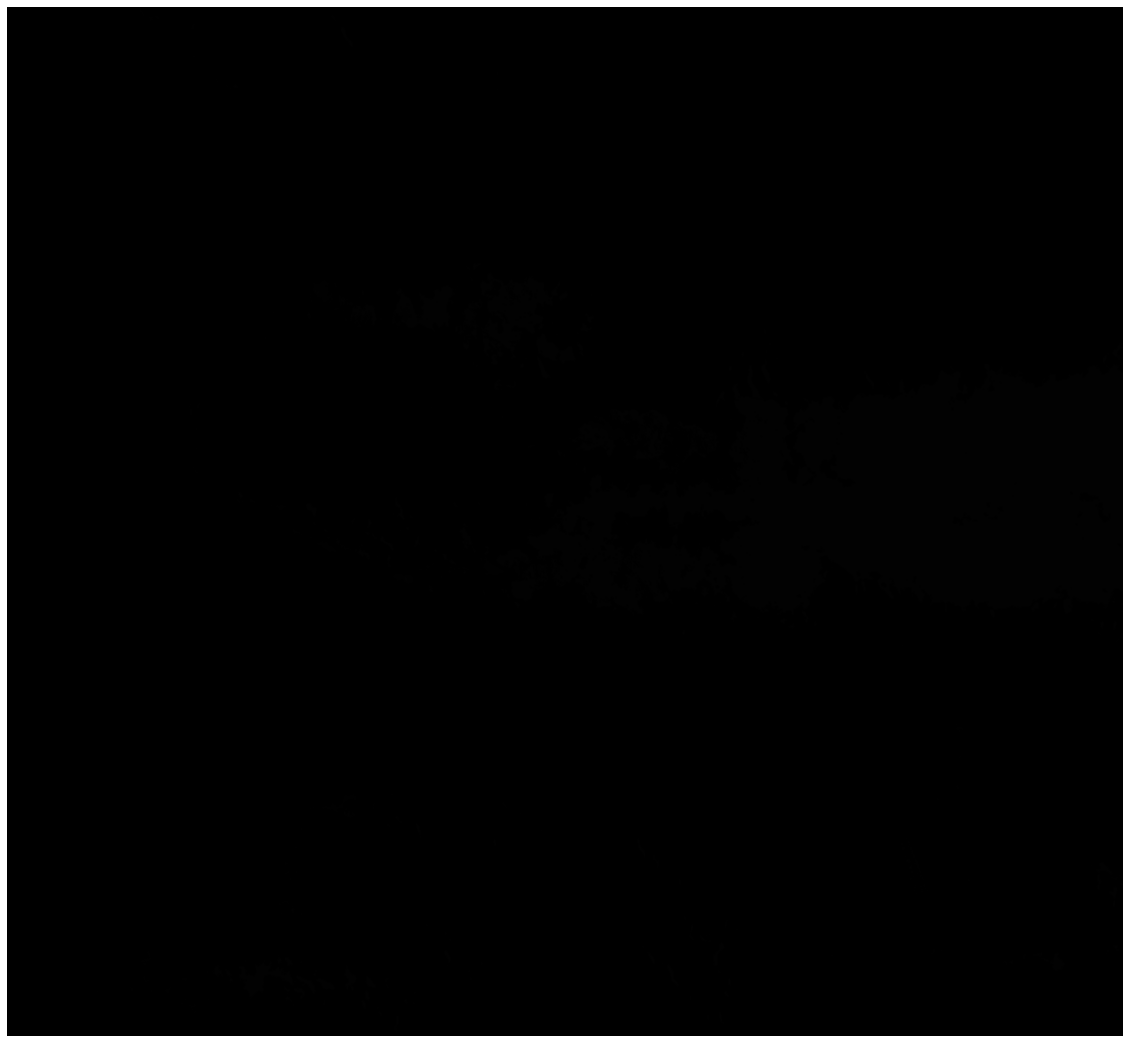

In [146]:
## Firstly fire, no fire. 

img = cv2.imread("data_label2/L_FS1_Gospers12019-12-06.png")
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img[(img[:,:,0]!=255) & (img[:,:,2]!=255) ] = 0
# img[(img[:,:,2]!=255) ] = 0
img[img[:,:,0]==255] = 1 ## Set this to 255 if want to see clearly in image ## Indicates that is fire (Class = 1 -> Fire)
img[img[:,:,2]==255] = 2 ## 2 = cloud 

##Set thes to 125 and 255 if u want to see it visualised in the plot

plt.figure(figsize = (20,20))
plt.imshow(img)
plt.axis("off")
plt.show()

In [147]:
## Fire, cloud, background for dataset with more cloud cover 

label2_dir = os.listdir('data_label2')

for img_name in label2_dir:
    print(img_name)
    img = cv2.imread('data_label2/' + img_name)
    img[(img[:,:,0]!=255) & (img[:,:,2]!=255) ] = 0
    img[img[:,:,0]==255] = 1 ## Set this to 255 if want to see clearly in image ## Indicates that is fire (Class = 1 -> Fire)
    img[img[:,:,2]==255] = 2 ## 2 = cloud 

    cv2.imwrite("data_label2_masks_fc/M" + img_name, img) 

L_NFS32020-01-05.png
L_NFS22020-01-23.png
L_NFS72020-03-01.png
L_NFS12019-12-13.png
L_NFS62019-12-17.png
L_NFS42020-01-01.png
L_NFS52019-12-12.png
L_FS3_Currowan2019-12-26.png
L_NFS52019-12-07.png
L_NFS42019-12-21.png
L_NFS52020-01-26.png
L_NFS72020-01-11.png
L_NFS12019-12-06.png
L_NFS12020-01-27.png
L_FS5_EGippsland2019-11-21.png
L_NFS22019-12-17.png
L_NFS32020-01-10.png
L_NFS22020-01-08.png
L_NFS12020-01-25.png
L_FS4_OrroralValley2019-12-04.png
L_FS4_OrroralValley2020-01-25.png
L_NFS62020-01-21.png
L_FS3_Currowan2020-01-10.png
L_FS1_Gospers12020-02-04.png
L_FS6_KangarooIsland2020-02-09.png
L_NFS52020-01-31.png
L_NFS72019-12-27.png
L_FS4_OrroralValley2020-01-30.png
L_FS4_OrroralValley2019-12-11.png
L_NFS12019-12-11.png
L_NFS12020-01-30.png
L_FS2_Gospers22020-02-04.png
L_NFS32019-12-26.png
L_FS5_EGippsland2020-02-17.png
L_NFS22019-12-14.png
L_NFS22019-12-04.png
L_NFS22020-01-31.png
L_FS5_EGippsland2020-02-07.png
L_FS2_Gospers22020-02-14.png
L_FS2_Gospers22019-11-21.png
L_FS4_OrroralVal

In [148]:
## Fire cloud, background  for dataset with less cloud cover

label2_dir = os.listdir('data_nc_label2')

for img_name in label2_dir:
    print(img_name)
    img[(img[:,:,0]!=255) & (img[:,:,2]!=255) ] = 0
    img[img[:,:,0]==255] = 1 ## Set this to 255 if want to see clearly in image ## Indicates that is fire (Class = 1 -> Fire)
    img[img[:,:,2]==255] = 2 ## 2 = cloud 
    cv2.imwrite("data_nc_label2_masks_fc/M" + img_name , img) 

L_NFS32020-01-05.png
L_NFS22020-01-23.png
L_NFS72020-03-01.png
L_NFS12019-12-13.png
L_NFS62019-12-17.png
L_NFS42020-01-01.png
L_FS3_Currowan2019-12-26.png
L_NFS52019-12-07.png
L_NFS42019-12-21.png
L_NFS52020-01-26.png
L_NFS72020-01-11.png
L_NFS12019-12-06.png
L_NFS12020-01-27.png
L_NFS22019-12-17.png
L_NFS32020-01-10.png
L_NFS22020-01-08.png
L_NFS12020-01-25.png
L_FS4_OrroralValley2019-12-04.png
L_FS4_OrroralValley2020-01-25.png
L_NFS62020-01-21.png
L_FS1_Gospers12020-02-04.png
L_FS6_KangarooIsland2020-02-09.png
L_NFS52020-01-31.png
L_FS4_OrroralValley2020-01-30.png
L_FS4_OrroralValley2019-12-11.png
L_NFS12019-12-11.png
L_NFS12020-01-30.png
L_FS2_Gospers22020-02-04.png
L_NFS32019-12-26.png
L_NFS22019-12-14.png
L_NFS22019-12-04.png
L_NFS22020-01-31.png
L_FS4_OrroralValley2020-01-08.png
L_NFS52020-01-21.png
L_FS1_Gospers12019-11-21.png
L_FS6_KangarooIsland2020-02-24.png
L_NFS42019-12-27.png
L_NFS72019-12-22.png
L_NFS12019-12-28.png
L_NFS22020-01-18.png
L_FS5_EGippsland2019-11-19.png
L_NF

In [219]:
os.getcwd()

'/Users/oliverbestel/Desktop/thesis_data'

In [234]:

label_dir = os.listdir('mask_images/')

label_dir.remove(".DS_Store")

# label_dir

for img_name in label_dir:
    print(img_name)
    img = cv2.imread('mask_images/' + img_name)
    img[(img[:,:,0]!=255) & (img[:,:,2]!=255) ] = 0
    img[img[:,:,0]==255] = 1 ## Set this to 255 if want to see clearly in image ## Indicates that is fire (Class = 1 -> Fire)
    img[img[:,:,2]==255] = 2 ## Gonna set cloud to 0 

    cv2.imwrite("true_masks_wcloud/" + img_name, img) 

515_2019-12-26.png
396_2019-12-06.png
843_2019-11-07.png
218_2019-11-21.png
27_2019-12-29.png
1551_2019-12-02.png
1115_2019-10-23.png
501_2019-10-27.png
59_2019-09-27.png
143_2019-10-10.png
1156_2019-10-28.png
1460_2019-10-18.png
1090_2019-10-22.png
163_2019-12-21.png
1465_2019-11-01.png
853_2019-09-03.png
382_2019-10-07.png
613_2019-12-17.png
453_2019-12-02.png
1222_2019-11-07.png
89_2019-12-21.png
551_2019-10-03.png
338_2019-12-26.png
1067_2019-10-23.png
1084_2019-09-07.png
1475_2019-12-21.png
173_2019-11-01.png
1113_2019-10-18.png
1430_2019-10-28.png
323_2019-10-25.png
187_2019-10-22.png
896_2019-12-11.png
1229_2019-12-21.png
960_2019-11-27.png
1559_2019-09-27.png
292_2019-10-28.png
1518_2019-11-17.png
403_2019-09-02.png
21_2019-12-06.png
329_2019-11-16.png
311_2019-12-17.png
257_2019-09-03.png
37_2019-11-21.png
162_2019-12-19.png
681_2019-09-23.png
92_2019-09-02.png
621_2019-10-18.png
931_2019-11-12.png
263_2019-10-07.png
1578_2019-10-23.png
324_2019-10-27.png
206_2019-10-03.png
10

In [229]:
## Fire, no fire

label_dir = os.listdir('mask_images/')

label_dir.remove(".DS_Store")

# label_dir

for img_name in label_dir:
    print(img_name)
    img = cv2.imread('mask_images/' + img_name)
    img[(img[:,:,0]!=255) & (img[:,:,2]!=255) ] = 0
    img[img[:,:,0]==255] = 1 ## Set this to 255 if want to see clearly in image ## Indicates that is fire (Class = 1 -> Fire)
    img[img[:,:,2]==255] = 0 ## Gonna set cloud to 0 

    cv2.imwrite("true_masks/" + img_name, img) 

515_2019-12-26.png
396_2019-12-06.png
843_2019-11-07.png
218_2019-11-21.png
27_2019-12-29.png
1551_2019-12-02.png
1115_2019-10-23.png
501_2019-10-27.png
59_2019-09-27.png
143_2019-10-10.png
1156_2019-10-28.png
1460_2019-10-18.png
1090_2019-10-22.png
163_2019-12-21.png
1465_2019-11-01.png
853_2019-09-03.png
382_2019-10-07.png
613_2019-12-17.png
453_2019-12-02.png
1222_2019-11-07.png
89_2019-12-21.png
551_2019-10-03.png
338_2019-12-26.png
1067_2019-10-23.png
1084_2019-09-07.png
1475_2019-12-21.png
173_2019-11-01.png
1113_2019-10-18.png
1430_2019-10-28.png
323_2019-10-25.png
187_2019-10-22.png
896_2019-12-11.png
1229_2019-12-21.png
960_2019-11-27.png
1559_2019-09-27.png
292_2019-10-28.png
1518_2019-11-17.png
403_2019-09-02.png
21_2019-12-06.png
329_2019-11-16.png
311_2019-12-17.png
257_2019-09-03.png
37_2019-11-21.png
162_2019-12-19.png
681_2019-09-23.png
92_2019-09-02.png
621_2019-10-18.png
931_2019-11-12.png
263_2019-10-07.png
1578_2019-10-23.png
324_2019-10-27.png
206_2019-10-03.png
10

In [6]:
img[250:300,250:300,:]

array([[[ 36,  45, 255],
        [ 36,  45, 255],
        [ 36,  44, 255],
        ...,
        [ 23,  30, 255],
        [ 23,  29, 255],
        [ 23,  29, 255]],

       [[ 36,  45, 255],
        [ 36,  44, 255],
        [ 36,  45, 255],
        ...,
        [ 23,  30, 255],
        [ 23,  30, 255],
        [ 23,  29, 255]],

       [[ 36,  44, 255],
        [ 36,  44, 255],
        [ 35,  44, 255],
        ...,
        [ 23,  30, 255],
        [ 23,  30, 255],
        [ 23,  29, 255]],

       ...,

       [[ 24,  30, 255],
        [ 24,  30, 255],
        [ 24,  30, 255],
        ...,
        [ 25,  32, 255],
        [ 25,  31, 255],
        [ 25,  31, 255]],

       [[ 24,  30, 255],
        [ 24,  30, 255],
        [ 24,  30, 255],
        ...,
        [ 24,  31, 255],
        [ 25,  31, 255],
        [ 24,  31, 255]],

       [[ 25,  30, 255],
        [ 24,  30, 255],
        [ 25,  30, 255],
        ...,
        [ 24,  31, 255],
        [ 24,  31, 255],
        [ 24,  31, 255]]

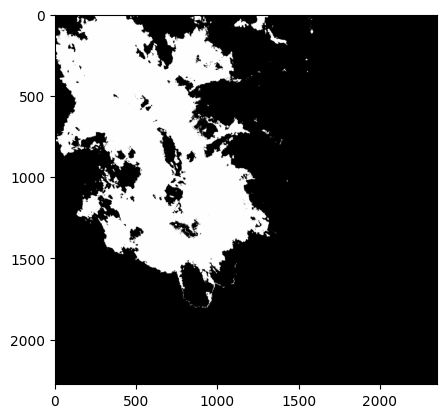

In [3]:
img = cv2.imread('true_masks_wcloud/9_2019-10-20.png')

plt.imshow(img*255)

In [ ]:
img = cv2.imread('true_masks_wcloud/9_2019-10-20.png')

plt.imshow(img*255)

In [ ]:
## Option to create patches. Not used currently with this second dataset. 

def split_image_into_patches(image, patch_size):
    print(image.shape)
    height, width, _ = image.shape
    patch_width, patch_height = patch_size

    patches = []
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
            if x + patch_width <= width and y + patch_height <= height:
                patch = image[y:y+patch_height, x:x+patch_width].copy()
                patches.append(patch)

    return patches


## Function for creating non-overlapping patches


def create_patches(path_to_data, output_folder, dims): 

    image_names = sorted(os.listdir(path_to_data))

    if ".DS_Store" in image_names:
        image_names.remove(".DS_Store")

    
    i = 0 

    for img in image_names:
        # print(img)

        if re.match(r".*(FS[1-9]_).*", img):

            # print('Pass')

            actual_image = cv2.imread(path_to_data + "/" + img)

            i_patches = split_image_into_patches(actual_image, dims)
            print("Len i_patches ", len(i_patches))

            for p in i_patches:

                cv2.imwrite(output_folder + "/{}.png".format(i), p )
                i+=1

    
    return 

# for img, mask in zip(image_patches, image_mask_patches):

#     fig, (ax, m_ax) = plt.subplots(ncols = 2)

#     ax.imshow(img * 3.5/255)
#     ax.set_title('Image Patch')
#     ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
#     ax.tick_params(axis = 'y' , left = False, labelleft = False)


#     m_ax.imshow(mask * 255)
#     m_ax.set_title('True Mask')
#     m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
#     m_ax.tick_params(axis = 'y' , left = False, labelleft = False)


In [7]:
## Load masks into numpy array 
directory = "true_masks_wcloud/"  ## We take the cloud included as we can always change this later

mask_filenames = [filename for filename in os.listdir(directory) if filename.endswith(('.png', '.jpeg', '.jpg'))]

masks = []
fire_files = []

for filename in mask_filenames:

    mask = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)

    mask = mask[0:2000, 0:2000]

    if np.count_nonzero(mask == 1) > 100:
        masks.append(mask)

        fire_files.append(filename)



masks_array = np.array(masks)

# Print the shape of the array
print("Shape of the images array:", masks_array.shape)

directory = "true_images"

# image_filenames = [filename for filename in os.listdir(directory) if filename.endswith(('.png', '.jpeg', '.jpg'))]

images = []

for filename in fire_files:

    image = cv2.imread(os.path.join(directory, filename))
    image = image[0:2000, 0:2000,:]



    images.append(image)

images_array = np.array(images)

print("Shape of the images array:", images_array.shape)

Shape of the images array: (177, 2000, 2000)
Shape of the images array: (177, 2000, 2000, 3)


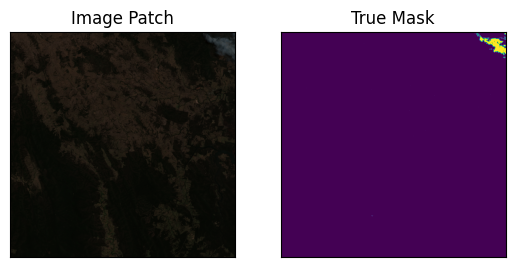

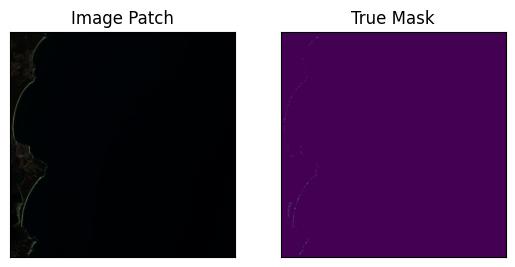

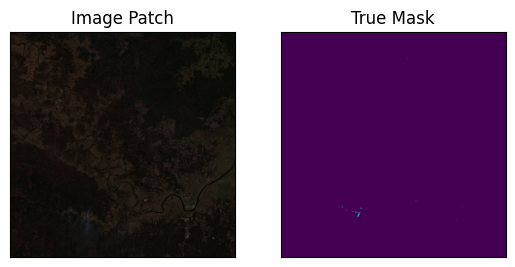

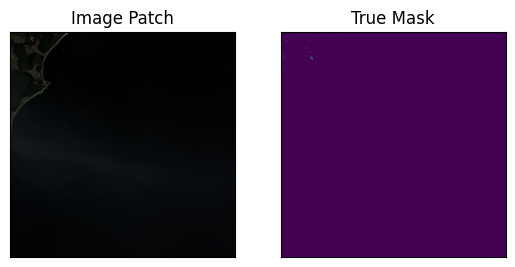

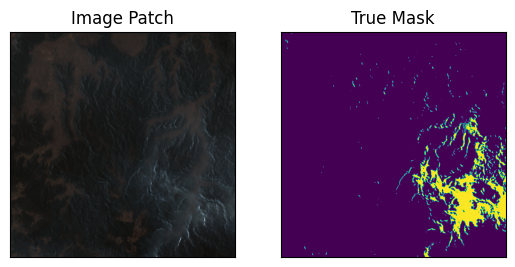

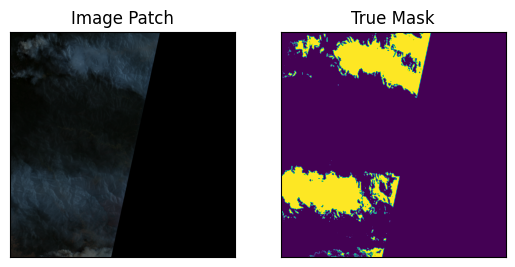

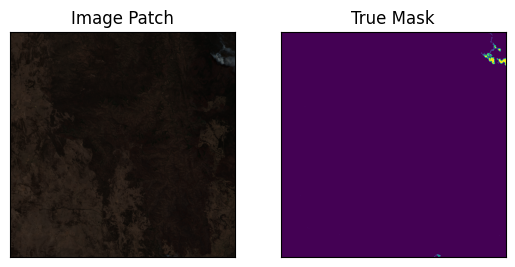

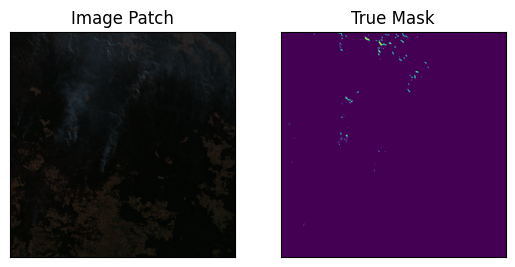

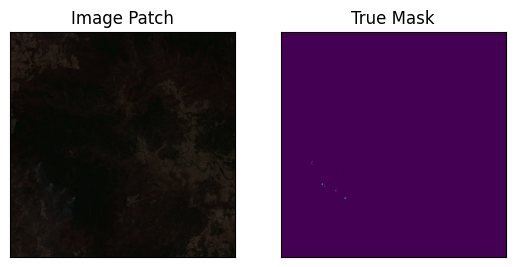

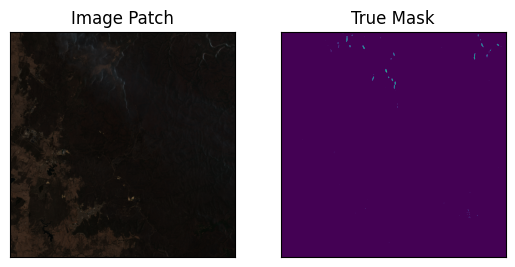

In [8]:
i = 0 
while i < 10: 
  i+=1 
  # plt.imshow(masks_array[i])


  fig, (ax, m_ax) = plt.subplots(ncols = 2)
  ax.imshow(images_array[i])
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)

  mask = masks_array[i]
  
  m_ax.imshow(masks_array[i])
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)